# Venn-ABERS demo

This interactive notebook illustrates some of the inner workings of the Venn-ABERS predictors, with detailed visualizations.

It is not meant to showcase the strengths and limitations, but only to provide insight into the method operates.


Author: Paolo Toccaceli, RHUL, 2018

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import matplotlib
matplotlib.rcParams['figure.figsize']=(14,10)

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML('<style>.text_cell_render { font-size: 16pt; }</style>'))

In [5]:
from ipywidgets import interact,FloatSlider,Layout,fixed

In [6]:
from sklearn.isotonic import IsotonicRegression

In [7]:
import VennABERS

In [9]:
def sigmoid(x,m=1,x0=0,y0=0):
    return np.exp(-np.logaddexp(0,-m*x+x0))-y0

In [24]:
def display_VennABERS(s,p0_sweep,p1_sweep,cal_scores,y_cal):
    # score_sweep
    f,((ax2,ax1),(ax3,ax4)) = plt.subplots(2,2)
    ax1.plot(score_sweep,p0_sweep,"g.",label="$p_0$");
    ax1.plot(score_sweep,p1_sweep,"r.",label="$p_1$");
    ax1.vlines(s,0,1,'b')    
    ax1.set_ylim(0,1)
    ax1.set_xlabel("Score")
    ax1.set_ylabel("Predicted $p_0$,$p_1$")
    ax1.set_title("Venn-ABERS calibrator")
    ax1.legend(loc="upper left")

    ir = IsotonicRegression()
    
    xr = np.r_[cal_scores,s]
    xr_as = np.argsort(xr)
    x = xr[xr_as]

    y = np.r_[y_cal,0][xr_as]
    ir.fit(x,y)
    p0 = ir.predict(x)
    
    _,i_p0 = np.unique(p0,return_index=True)
    x_bins = np.r_[x[i_p0],np.max(x)]
    ax3.hist((x[y==1],x[y==0]),
             bins=x_bins,
             stacked=True,
             alpha=0.3,lw=1,ec="k",label=['Positive','Negative'])
    ax3.vlines(s,0,1,'b')    
    ax3.set_title("Taxonomy for $p_0$ at $%f$"%s)
    leg = ax3.legend(loc='upper right')
    leg.get_frame().set_alpha(0.5)
    
    y = np.r_[y_cal,1][xr_as]
    ir.fit(x,y)
    p1 = ir.predict(x)

    _,i_p1 = np.unique(p1,return_index=True)
    x_bins = np.r_[x[i_p1],np.max(x)]
    ax4.hist((x[y==1],x[y==0]),
             bins=x_bins,
             stacked=True,
             alpha=0.3,lw=1,ec="k",label=['Positive','Negative'])
    ax4.vlines(s,0,1,'b')    
    ax4.set_title("Taxonomy for $p_1$ at $%f$"%s)
    leg = ax4.legend(fancybox=True,loc='upper right')
    leg.get_frame().set_alpha(0.5)
    ax4.get_shared_y_axes().join(ax4,ax3)
    ax3.autoscale()
    
    ax2.plot(x,p0,"go",label="ir for $y=0$");
    ax2.plot(x,p1,"ro",label="ir for $y=1$",alpha=0.5);
    ax2.vlines(s,0,1,'b')
    ax2.set_ylim(0,1)
    ax2.set_xlabel("Score")
    ax2.set_ylabel("Predicted $p_0$,$p_1$")
    ax2.set_title("Venn-ABERS predictor for $%f$"%s)
    ax2.legend(loc="upper left")


# Synthetic data

We obtain some synthetic data, by generating binary labels (0 or 1) with a probability that depends directly on a *score*.

Here, just as an example, we assume that the dependency can be expressed with a sigmoid of the scores.
A stochastic component is added (variates from a normal distribution). 

In [40]:
np.random.seed(101)   # for reproducibility

In [50]:
cal_scores = np.linspace(-10,2,100)                # range is deliberately arbitrary
base_s = sigmoid(cal_scores,m=0.5,y0=0.7,x0=-2)
s = base_s + 0.2*np.random.normal(size=cal_scores.shape)
y_cal = s>0                                       # labels are obtained as thresholding (>0) of sigmoid plus noise

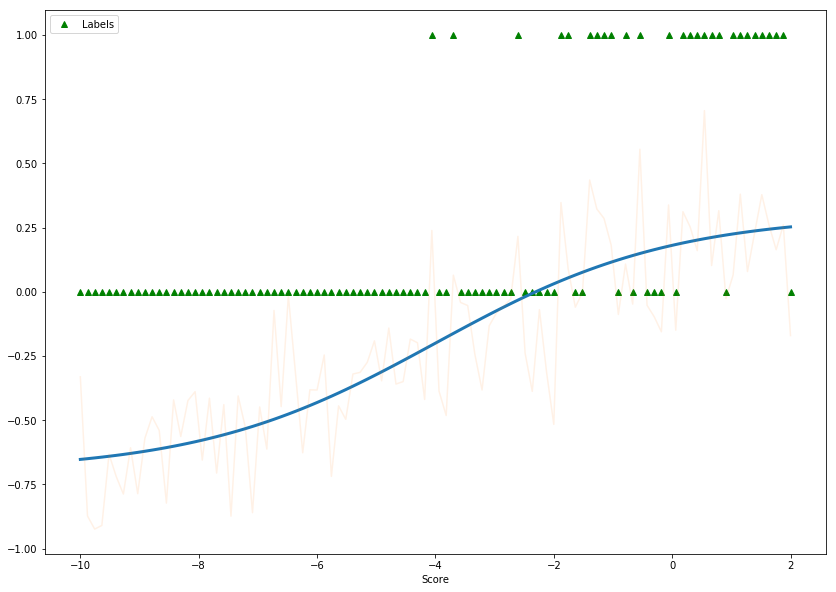

In [52]:
f,ax = plt.subplots()
ax.plot(cal_scores,y_cal,"g^",label="Labels");
ax.plot(cal_scores,base_s,lw=3);
ax.plot(cal_scores,s,alpha=0.1)
ax.legend(loc='upper left')
ax.set_xlabel("Score");


In [43]:
calibrPoints = list(zip(cal_scores,y_cal))

p0,p1 = VennABERS.ScoresToMultiProbs(calibrPoints,cal_scores)

In [44]:
score_sweep = np.linspace(np.min(cal_scores),np.max(cal_scores),400)
# The small step is to identify all VA interval 
# (it was actually obtained by lowering until no difference was found in np.unique(p1_sweep).shape below)

In [45]:
p0_sweep,p1_sweep = VennABERS.ScoresToMultiProbs(calibrPoints,score_sweep)

In [46]:
np.unique(p0_sweep).shape, np.unique(p1_sweep).shape

((20,), (52,))

In [47]:
p0_bins = np.concatenate((np.unique(p0_sweep),[1.0]))
p1_bins = np.concatenate(([0.0],np.unique(p1_sweep)))

# Venn-ABERS interactive demonstration

The interactive display below illustrates some key aspects of Venn-ABERS predictors.

In the top row, the plot on the right show the values of the predicted $p_0$ and $p_1$ as the value of the score $s$ varies.

The plot on the left shows the Isotonic Regressions that are calculated for each value $s$. There are 2 Isotonic Regressions, one obtained adding a hypothetical example $(s,0)$ to the calibration set and another obtained adding $(s,1)$. The value at $s$ of the former IR is what we take as $p_0(s)$ and the value at $s$ of the latter IR gives us $p_1(s)$. The intervals over which the IR is constant constitute the categories of the taxonomy of the Venn predictor. They are the intervals over which the distributions are computed.

Note that the taxonomy changes when $s$ changes. This may be counterintuitive. The taxonomy changes because we are adding a hypothetical example ($(s,0)$ in one case or $(s,1)$ in the other) to the set over which we are seeking the probability assignment (non-decreasing in $s$) that maximizes the likelihood. The theoretical basis of the method enables us to use Isotonic Regression which aims to minimize the sum of square residues. This results in a piecewise continuous function. The value of the IR is the proportion of positive labels among the calibration set of objects falling in the interval. 

In more concrete terms, let's consider what happens when we already computed an IR and we add a point. The point falls in a interval where the IR is constant and takes the value of the proportion of positive examples.  If we were to add an example there, we would change this proportion, increasing it if adding an example with label 1 and decreasing if adding an example with label 0. One can immediately realize that the taxonomy has to change if as a result the new proportion is less than the one in the preceding interval or greater than the one in the successive interval, because this would violate the isotonicity.

In [48]:
interact(display_VennABERS,
         s = FloatSlider(value=0,min=-10,max=2,step=0.01,
                              layout=Layout(width='50%'),continuous_update=False),
         p0_sweep = fixed(p0_sweep),
         p1_sweep = fixed(p1_sweep),
         cal_scores = fixed(cal_scores),
         y_cal= fixed(y_cal));

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='s', layout=Layout(width='50%'), max=2.0, min=-10.0, step=0.01), Output()), _dom_classes=('widget-interact',))

The bottom row has plots that may help illustrating how the taxonomies vary. 

The plots show the taxonomies induced by the Venn-ABERS on the "calibration set plus $(s,0)$" on the left and "calibration set plus $(s,1)$" on the right. 

Each bin corresponds to one category in the taxonomy. The bar heights show the counts of positive examples (in blue) and of negative examples (in beige).

In each bin, we calculate the proportion of calibration set examples belonging to the Positive class. This value is the predicted probability and is shared by all the objects that fall in the bin. Note, for a given calibration set, the value of the predicted probability on a bin depends only on the choice of the edges of the bin.
The bins are determined by the Isotonic Regression, so that the sum of square residues between predicted probabilities and actual labels over the examples of the calibration set is minimized (a theorem by Brunk shows that the probabilities obtained in this also minimize the likelihood of calibration data).

Note that, in fact, we are only interested in the predicted probability in the bin in which the test example falls. This is the probability output by the Venn-ABERS predictor; $p_0$ is taken from the taxonomy on the left and $p_1$ from the taxonomy on the right.